# Bayesian Optimization: Searching for the global minima
**You should hand in a report, via Canvas, maximum 6 pages (excluding references). 
Do not attach any appendices. In the report you should present your data, models and the final results.
Do not forget to visualize your data and results.
It is important that you discuss your findings and reflect on the results.
In addition you need to hand in your Python code.
The code itself will not be graded, but it should run without errors and upon inspection reproduce the main results you present in the report.
Emphasis will be put on your ability to use appropriate terminology to describe and discuss the employed statistical methodologies and results.**

**<font color=red>DEADLINE: Dec 8 (Tuesday), 23:59</font>**

## Background
In this project you will explore and search the potential energy surface (PES) for an Au atom placed on top of a Au surface.
We will use a gold surface with Miller indices (433), which is so-called vicinal surface, corresponding to stepped (111) surface.
The Au atom  placed ontop of the surface is refered to as an ad-atom.

<img src="images/surface_433.png" alt="Drawing" style="width: 850px;"/>

Here the left image shows a side view of the surface with the ad-atom colored in red.
The right image shows the top view ($z$-direction) of the surface with the primitive cell marked as the smaller rectangle drawn in black.

Finding the position of the ad-atom with the lowest energy is a difficult problem as there are multiple local minima in the PES.
Furthermore, evaluating the potential energy is commonly done with density functional theory (DFT) which is very computationally expensive and hence it is desirable to keep the number of potential energy calculations as low as possible.
To tackle these two problems we will employ Bayesian optimization using Gaussian Processes.

Additional information on a very similar task can be found in the [paper by Todorovic *et al.*](https://doi.org/10.1038/s41524-019-0175-2), a copy of which (`Todorovic-2019.pdf` is included in this directory).

## Atomstic structure
Here, instead of DFT, we will use an embedded medium theory calculator which is provided in [`ase`](https://wiki.fysik.dtu.dk/ase/index.html) or [`asap`](https://wiki.fysik.dtu.dk/asap).
You are given a atomistic surface in `structures/surface_supercell.xyz`, which can be read as
``` python
from ase.io import read
surface = read('structures/surface_supercell.xyz')
```
When searching for the optimal location of the ad-atom we only need to consider positions inside the primitive cell since the PES will be repeating itself if we move outside the primitive cell.
We therefore only consider position in the domain
\begin{equation}
0 < x < 16.65653 \quad  \land \quad 0 < y < 2.884996
\end{equation}


## Evaluating the PES
The ad-atom energy of interest, $E$, is defined as by
\begin{equation}
E = E_\text{ad} - E_\text{surface},
\end{equation}
where $E_\text{ad}$ is the potential energy of the system with the ad-atom present and $E_\text{surface}$ the energy of just the bare surface system.
When evaluating the PES, we consider the surface to be completly rigid and only allow the ad-atom to move.
The energy can thus be written as 
\begin{equation}
E = E(x,y,z),
\end{equation}
where $(x,y,z)$ corresponds to the position of the ad-atom.
Here, we will allow the $z$-coordinate of the ad-atom to relax to its local minima (given $x$ and $y$) and thus only consider the $x-y$ dependency of the energy, meaning we write the energy $E$ as
\begin{equation}
E(x, y) = \min_z E(x, y, z).
\end{equation}
The primary goal of this project is to find the global minimum of the function $E(x, y)$ in as few evaluations of $E(x, y)$ as possible.


## Bayesian Optimization
To this end, we turn to Bayesian optimization using Gaussian processes (GPs).
The idea is to iteratively train a GP to model the energy, $E(x, y)$, and use it to suggest new possible samples.

Let $\mathbf{X}$ be an array of shape $(N, 2)$ containing $(x, y)$ points as rows and $\boldsymbol{E}$ an array of length $N$ with energies corresponding to $E(x,y)$ for each point in $\mathbf{X}$.
First we construct an initial model from a few randomly drawn samples $\mathbf{X}$ and their corresponding energies $\boldsymbol{E}$.       
This allows us to train a GP for the given $\mathbf{X}$ and $\boldsymbol{E}$, which provides both an average value $\mu$ and a standard deviation $\sigma$ for the energy at $(x, y)$.

The next step is to select a new point $(x_\text{new},y_\text{new})$ for sampling.
This is done by finding the point $(x_\text{new},y_\text{new})$ in the domain that maximizes the so-called acquisition function $A(x, y)$.
In this project, we recommend using the lower confidence  bound (LCB) acquisition function, which is defined as 
\begin{equation}
A(x, y) = -\mu (x, y) + \beta \sigma (x,y).
\end{equation}
Here, $\beta$ is a hyperparameter that can be chosen approximately from the range 1 to 5.
A large value of $\beta$ will favor more exploration whereas a smaller value will lead to more exploitation.
* **Exploitation:** Search regions with low mean (low energy)
* **Exploration:** Search regions with high uncertainty/variance
You can also adaptively adjust $\beta$ during the Bayesian optimization.
Can you think of suitable protocols?

A new data point can thus be selected by
\begin{equation}
(x_\text{new}, y_\text{new}) = \arg \max_{x, y} A(x, y)
\end{equation}
Next the energy at this new point, $E(x_\text{new}, y_\text{new})$, is evaluated and added to our samples $\mathbf{X}$ and $\boldsymbol{E}$.
This allows a new GP model to be trained and we can iterate through this procedure until convergence is (hopefully) reached.


## GPy optimization
Setting up your GP model can be achieved using a snippet such as the following
```python
k1 = GPy.kern.RBF(input_dim=2)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2
model = GPy.models.GPRegression(x_data, y_data, kernel)
model.optimize()
print(model)
```
Where `model.optimize` will find the variance, length scale and bias that maximizes the log-likelihood for the GP.
The log-likelihood may be very flat or contain multiple local minima.
In case you end up with strange parameters (such as the lengthscale being $10^{-10}$ or $10^{10}$), it can help to rerun the optimization a few times which can automatically be done via
``` python
model.optimize_restarts()
```
Additionaly, it might help to put some reasonable constraints on the parameters, via
```python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].constrain_bounded(0.1, 5)
```
Instead of strict constraints, one can also set priors over the parameters via, e.g.,
``` python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
```

## Helper function for z-relaxation
Below is a helper function that you can use to carry out the relaxation over $z$.
It might be helpful to also define a function only taking $(x, y)$ as argument and setting $z$ to, e.g.,
```python
z = surface[:, 2].max() + 3
```
to make sure the ad-atom sits on top of the surface, and then pass $(x,y,z)$ into `calculate_adatom_energy`.

In [1]:
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase import Atom
from asap3 import EMT
#from ase.calculators.emt import EMT


def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-cooridnate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y, z) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(Atom('Au', position))
    
    # attach calculator
    calc = EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy = surface_with_adatom.get_potential_energy()
    return energy

## Setup
In this project you will need [`ase`](https://wiki.fysik.dtu.dk/ase/index.html), [`asap`](https://wiki.fysik.dtu.dk/asap) and [`GPy`](https://sheffieldml.github.io/GPy/).

In [2]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt


import ase
from ase import Atoms
from ase.io import read
from ase.visualize import view
import scipy as sc

#import asap3
import GPy

from tqdm import tqdm
from tqdm.notebook import tqdm

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

## Task 1: Analyzing the PES (1.5p)
The first task of the project will be to generate and visualize the full PES, $E(x, y)$, on a grid for $(x,y)$.
This will give you access to the global minima by visual inspection and will help with understanding, e.g.,  how the optimization algorithms are working or whether they get stuck in the wrong minimum.

This task may take a few minute to run as it requires a lot of evaluations of the PES.

**Tasks:**
* Compute the PES, $E(x, y)$, on a dense grid for $x$ and $y$.
* Visualize the 2D PES as a heatmap.

In [3]:
def set_z_max(surface):
    z = surface[:, 2].max() + 3
    return z

surface = read('structures/surface_supercell.xyz')
view(surface, viewer='x3d')

In [4]:
x_max = 16.65653
y_max = 2.884996
xs = np.linspace(0.01, x_max, 50)
ys = np.linspace(0.01, y_max, 50)
z = set_z_max(surface.get_positions())

pes_file = 'pes.p'
if os.path.isfile(pes_file):
    print('Loading pickled PES')
    pes = pickle.load(open( pes_file, "rb" ))
else:
    print('Running PES calculation')
    pes = np.zeros((len(xs), len(ys)))
    for i, x in tqdm(enumerate(xs)):
        for j, y in enumerate(ys):
            energy = calculate_adatom_energy(surface, [x, y, z])
            pes[i,j] = energy
    pickle.dump(pes, open(pes_file, "wb"))

Loading pickled PES


7.096180860881837
8.123102364460468
(10, 12)


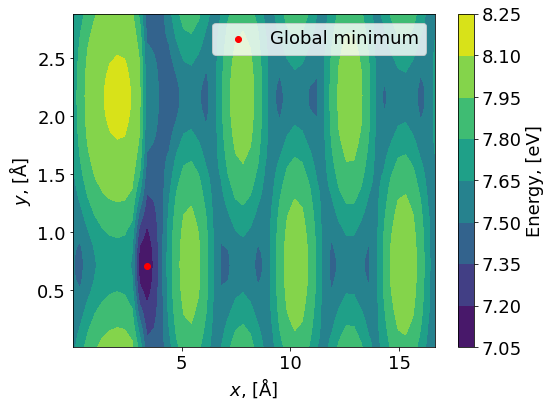

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
print(np.min(pes.flatten()))
print(np.max(pes.flatten()))
cs = ax.contourf(xs, ys, pes.T)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Energy, [eV]')
ax.set_xlabel(r'$x$, [Å]')
ax.set_ylabel(r'$y$, [Å]')
plt.tight_layout()

min_idx = np.ndarray.argmin(pes)
u_idx = np.unravel_index(min_idx, shape=pes.shape)
print(u_idx)
ax.scatter(x=xs[u_idx[0]], y=ys[u_idx[1]], c='r', label='Global minimum')
ax.legend(loc='best')


## Task 2: Local search (3p)

In this task you will try out local search (gradient descent) and see how it succeeds or fails for our function $E(x,y)$.

For the local search consider a random starting position uniformly drawn from the $\{x,y\}$ domain.

**Tasks:**
* From visual inspection of the PES in Task 1, can you obtain a rough estimate for the percentage of local searches that would end up in the global minimum.
* Run a few (50-500) local searches and record how many ended up in the global minimum.

*Hint:* `scipy.optimize.minimize` can be used

Loading pickled res
7.096180860881837
8.123102364460468
How many walkers ended up in the global minimum 75 15.0 %


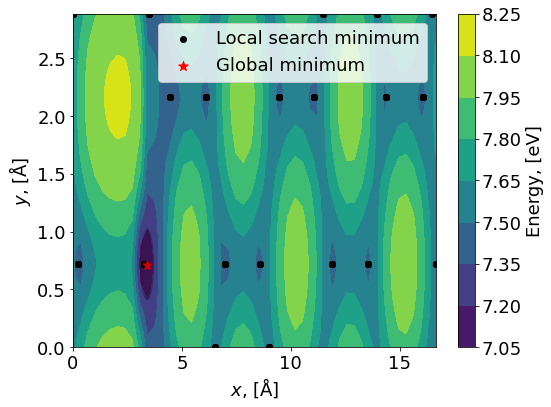

In [6]:
def PES(pos, z, surface):
    return calculate_adatom_energy(surface, [pos[0], pos[1], z])

n_walkers = 500

res_file = 'res.p'
if os.path.isfile(res_file):
    print('Loading pickled res')
    res = pickle.load(open( res_file, "rb" ))
else:
    print('Running scipy calculation')
    start_x = np.random.rand(n_walkers)*np.max(xs)
    start_y = np.random.rand(n_walkers)*np.max(ys)
    start = np.array([start_x, start_y])

    res = []
    for i, s in tqdm(enumerate(start.T)):
        res.append(sc.optimize.minimize(fun=PES, x0=s, args=(z, surface), bounds=((0, np.max(xs)), (0, np.max(ys)))))
    pickle.dump(res, open(res_file, "wb"))

fig, ax = plt.subplots(figsize=(8,6))
print(np.min(pes.flatten()))
print(np.max(pes.flatten()))
cs = ax.contourf(xs, ys, pes.T)
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Energy, [eV]')
ax.set_xlabel(r'$x$, [Å]')
ax.set_ylabel(r'$y$, [Å]')
plt.tight_layout()

min_idx = np.ndarray.argmin(pes)
u_idx = np.unravel_index(min_idx, shape=pes.shape)

gm_x = xs[u_idx[0]]
gm_y = ys[u_idx[1]]




tol = 0.3
circle = plt.Circle((gm_x, gm_y), tol, color="k", alpha = 0.2)
ax.add_artist(circle)

count = 0
for i, r in enumerate(res):
    if i==0:
        ax.scatter(r.x[0], r.x[1], c="k", label='Local search minimum')
    else: 
        ax.scatter(r.x[0], r.x[1], c="k")
    if((r.x[0] - gm_x)**2 + (r.x[1] - gm_y)**2 < tol**2):
        count += 1
ax.scatter(x=gm_x, y=gm_y, c='r', marker='*', s=100, label='Global minimum')
ax.legend(loc='best')
ax.set_xlim((0,x_max))
ax.set_ylim((0,y_max))
print("How many walkers ended up in the global minimum", count, count/n_walkers*100, "%")
plt.tight_layout()
plt.savefig('figures/task12.png')

## Task 3: Bayesian optimization (8p)
Implement your own Bayesian optimization algorithm (using GPy for the Gaussian process part) and run it to find the global minima of $E(x, y)$.

Use the [RBF kernel](https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf) and include a Bias kernel if it is needed.

Suitable $\beta$ values might be in the range 1 to 5.

Start the Bayesian optimization from five (5) randomly drawn samples.        


**Tasks:**
* Given the PES in Task 1 choose and motivate priors for the lengthscale and variance parameters in the RBF kernel.
* Run Bayesian optimization and analyze how the choice of $\beta$ influences convergence. Select a good value for $\beta$.
* Rerun bayesian optimization with the selected $\beta$. How many iterations are needed until the global minimum is reached?
* Visualize the PES, the uncertainty ($\sigma$) and the acquisition function together with your samples for the final model.
* In what regions is the final GP model the most uncertain? Why?


*Hints:*
* If your algorithm gets stuck sampling the same points over and over again, try increasing $\beta$ (more exploration).         
* To find the argmax of $A(x, y)$ you can either evaluate it on a very dense grid or run multiple local searches (starting from random positions) and take the maximum obtained.

In [7]:
def get_initial_data(n_data = 5):

    start_x = np.random.rand(n_data)*x_max
    start_y = np.random.rand(n_data)*y_max

    z = set_z_max(surface.get_positions())
    X_data = np.zeros((n_data,2))
    E_data = np.zeros((n_data,1))
    for i in range(n_data):
        energy = calculate_adatom_energy(surface, [start_x[i], start_y[i], z]) 
        E_data[i] = energy
        X_data[i,0] = start_x[i]
        X_data[i,1] = start_y[i]
    return X_data, E_data


def train_GP(X_data, E_data): # put in priors
    k1 = GPy.kern.RBF(input_dim=2)
#     k1 = GPy.kern.StdPeriodic(input_dim=2,  period=[x_max, y_max], ARD1=True, ARD2=False)
    k2 = GPy.kern.Bias(input_dim=2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=0.5), warning=False)
    k1['variance'].set_prior(GPy.priors.Gamma(a=1, b=0.1), warning=False)
    kernel = k1 + k2
#     kernel = k1
    model = GPy.models.GPRegression(X_data, E_data, kernel)
#     model.sum.std_periodic.lengthscale[[0]].constrain_bounded(0.1, 5, warning=False)
#     model.sum.std_periodic.lengthscale[[1]].constrain_bounded(0.1, 1, warning=False)
#     model.sum.std_periodic.period[[0]].constrain_bounded(x_max-0.1, x_max+0.1, warning=False)
#     model.sum.std_periodic.period[[1]].constrain_bounded(y_max-0.1, y_max+0.1, warning=False)
    model.optimize()
    return model


def acquisition(x,model,beta, drop_mean=False):
    if drop_mean:
        return np.sqrt(model.predict(x)[1])
    else:
        return -model.predict(x)[0] + beta*np.sqrt(model.predict(x)[1])

def flatten_grid(nx = 50,ny = 50):
    x = np.linspace(0.01, x_max, nx)
    y = np.linspace(0.01, y_max, ny)
    X = np.zeros((nx*ny,2))
    k = 0
    for i in range(nx):
        for j in range(ny):
            X[k,0] = x[i]
            X[k,1] = y[j]
            k+=1
    return X

def get_new_X(model, beta, X, drop_mean=False): 
    Acq = acquisition(X,model,beta, drop_mean)
    new_X = np.argmax(Acq)
    return X[new_X,:], Acq


def plot_on_grid(f, ax, nx = 50,ny = 50):
    x = np.linspace(0.01,xs[-1],nx)
    y = np.linspace(0.01,ys[-1],ny)
    cs = ax.contourf(x, y, f)
    cbar = plt.colorbar(cs, ax=ax)
    cbar.ax.set_ylabel(r'Energy, [eV]')
    ax.set_xlabel(r'$x$, [Å]')
    ax.set_ylabel(r'$y$, [Å]')
    plt.tight_layout()

In [8]:
def bayesian_optimization(initial_X, initial_E, conv_tol, max_iters, n_data, nx, ny, beta, plot=True, debug=False):
    fig, ax = plt.subplots(figsize=(8,6))
    np.random.seed(4)

    z = set_z_max(surface.get_positions())

    X_new = []
    X_old = initial_X[-1,:]

    Xs = np.zeros((max_iters+n_data,2))
    E = np.zeros((max_iters+n_data,1))
    
    Xs[0:n_data,:] = initial_X
    E[0:n_data,:] = initial_E
    
    flat_grid = flatten_grid(nx,ny)
    for i in tqdm(range(max_iters)):
        model = train_GP(Xs[0:(n_data+i),:],E[0:(n_data+i),:])
        X_new, Acq = get_new_X(model, beta, flat_grid)
        E_new = calculate_adatom_energy(surface, [X_new[0], X_new[1], z]) 
        
        # Update data
        #X = np.append(X, X_new.reshape(1,2), axis=0)
        #E = np.append(E, np.array([E_new]).reshape(1,1), axis = 0)
        Xs[n_data+i,:] = X_new
        E[n_data+i,:] = E_new
        
        # cheeck convergence
#       dist = (X_new[0]-X_old[0])**2 + (X_new[1]-X_old[1])**2
        dist = (X_new[0]-gm_x)**2 + (X_new[1]-gm_y)**2
        if dist < conv_tol**2:
            break

        X_old = X_new
    iters = i+1

    if plot:
        plot_on_grid(Acq.reshape(nx,ny).T, ax, nx, ny)
        ax.scatter(x=Xs[:,0], y=Xs[:,1], c='b')
        ax.scatter(x=X_old[0], y=X_old[1], c='g')
        ax.scatter(x=X_new[0], y=X_new[1], c='r')
    
    return iters, model, Acq, Xs


Beta=1.00




Name : GP regression
Objective : 4.312284781350007
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  sum.rbf.variance         |   0.05833380364328906  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |    0.5076161976862433  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |     59.12116942718855  |      +ve      |            
  Gaussian_noise.variance  |  0.000681431177153287  |      +ve      |            
Beta=1.21




Name : GP regression
Objective : -13.65177738613922
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |   0.046254321800859276  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.5338055430746731  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      58.64087264571265  |      +ve      |            
  Gaussian_noise.variance  |  3.174573347968174e-35  |      +ve      |            
Beta=1.42




Name : GP regression
Objective : 2.126003757964991
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |    0.06882150845393017  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.5711803491170013  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |     59.205046043890846  |      +ve      |            
  Gaussian_noise.variance  |  0.0005931425252448829  |      +ve      |            
Beta=1.63


 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1




Name : GP regression
Objective : -55.084575984026095
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |     0.07120035675796721  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.4778429906669806  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.20704829377404  |      +ve      |            
  Gaussian_noise.variance  |  1.1037484906508945e-18  |      +ve      |            
Beta=1.84




Name : GP regression
Objective : -55.05553331771081
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |    priors  
  sum.rbf.variance         |  0.06624475278183414  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |   0.4626123916782487  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |    59.20609550210354  |      +ve      |            
  Gaussian_noise.variance  |  1.8310878514819e-37  |      +ve      |            
Beta=2.05




Name : GP regression
Objective : -36.224693662034255
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |    0.07475651313149524  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.4893321837190858  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      59.34426976861529  |      +ve      |            
  Gaussian_noise.variance  |  7.272636144685257e-31  |      +ve      |            
Beta=2.26




Name : GP regression
Objective : 12.40171184100827
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  sum.rbf.variance         |   0.06580572856743336  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |    0.5933829064352597  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |     59.08286841985347  |      +ve      |            
  Gaussian_noise.variance  |  0.007419430147779249  |      +ve      |            
Beta=2.47




Name : GP regression
Objective : -39.589749394228676
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |     0.06253807075412089  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.6037670588605515  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      59.934968931447195  |      +ve      |            
  Gaussian_noise.variance  |  1.4072902973764743e-40  |      +ve      |            
Beta=2.68




Name : GP regression
Objective : -39.96055426139704
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |     0.04459928171317317  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.42971482839501635  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       58.95047239298503  |      +ve      |            
  Gaussian_noise.variance  |  1.8044528602431047e-33  |      +ve      |            
Beta=2.89




Name : GP regression
Objective : -13.210812045370979
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |   0.053778440935752944  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.5024628173973218  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      58.86221754242509  |      +ve      |            
  Gaussian_noise.variance  |  4.192510236613616e-28  |      +ve      |            
Beta=3.11




Name : GP regression
Objective : -30.423595027392736
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |    0.042021382413016256  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.5263811747654428  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.57355315889656  |      +ve      |            
  Gaussian_noise.variance  |  1.6634228778626412e-26  |      +ve      |            
Beta=3.32




Name : GP regression
Objective : -327.1033271037022
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |      0.0364989888350545  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.4244076903549075  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.66125543317748  |      +ve      |            
  Gaussian_noise.variance  |  2.2949142955483574e-47  |      +ve      |            
Beta=3.53




Name : GP regression
Objective : -13.34899764640905
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |    0.04236952776315154  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.4889837664750256  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      59.57142122601806  |      +ve      |            
  Gaussian_noise.variance  |  7.581851731624781e-49  |      +ve      |            
Beta=3.74




Name : GP regression
Objective : -14.439030397033818
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |     0.03933071451120395  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.4599571347026501  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.46909881763881  |      +ve      |            
  Gaussian_noise.variance  |  3.3994528158187186e-32  |      +ve      |            
Beta=3.95




Name : GP regression
Objective : -14.905173828186793
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |    0.03872759426711637  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |    0.41544249317685866  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      59.57717620380299  |      +ve      |            
  Gaussian_noise.variance  |  2.149034437940265e-15  |      +ve      |            
Beta=4.16




Name : GP regression
Objective : -21.26542025862259
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |   0.033699199917107514  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.4386570705411102  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      94.84560079952587  |      +ve      |            
  Gaussian_noise.variance  |  6.027397264554003e-10  |      +ve      |            
Beta=4.37




Name : GP regression
Objective : -38.968753648044256
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |    0.03535789606535123  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.5498300644092597  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.7641765940174  |      +ve      |            
  Gaussian_noise.variance  |  4.593576193187543e-27  |      +ve      |            
Beta=4.58




Name : GP regression
Objective : -68.62428175951206
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |    priors  
  sum.rbf.variance         |   0.037195134344794975  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |     0.5569649610755631  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |      59.75727137074492  |      +ve      |            
  Gaussian_noise.variance  |  3.971589287547016e-63  |      +ve      |            
Beta=4.79




Name : GP regression
Objective : -41.82592081247403
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |    0.036647691490408384  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.5031630840833603  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.75588999879554  |      +ve      |            
  Gaussian_noise.variance  |  1.6595964524277837e-23  |      +ve      |            
Beta=5.00




Name : GP regression
Objective : -45.58506654557388
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |    0.037103061143998715  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |       0.563259998081707  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.77703756294575  |      +ve      |            
  Gaussian_noise.variance  |  2.7574289582962682e-47  |      +ve      |            


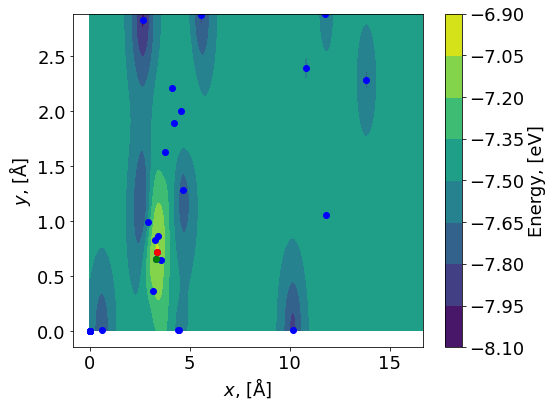

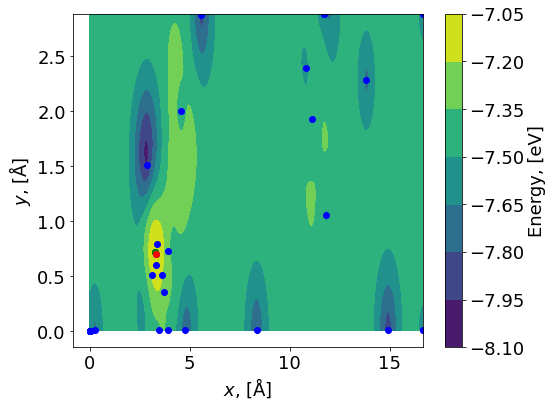

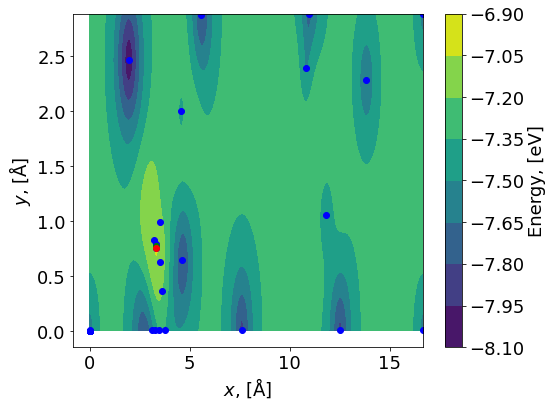

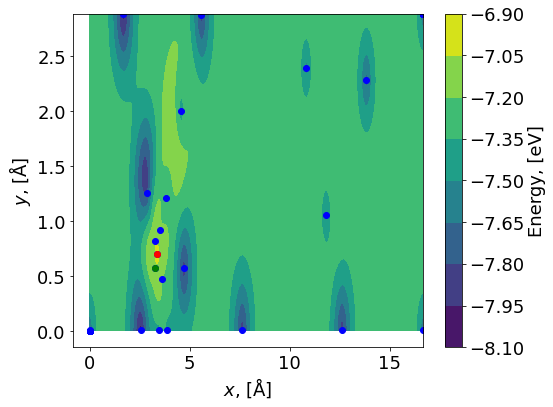

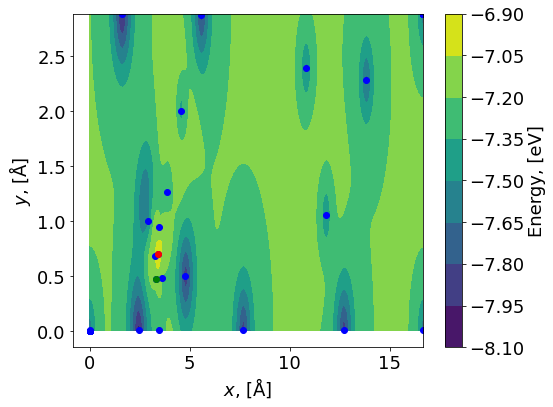

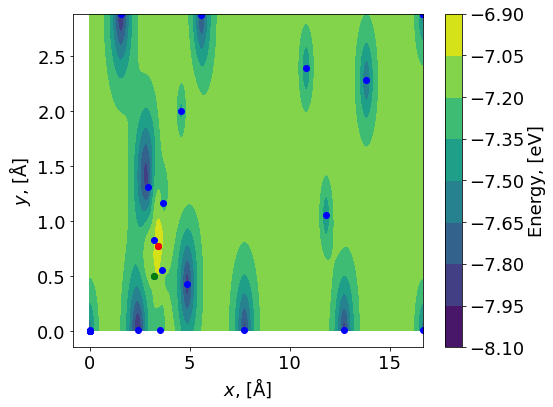

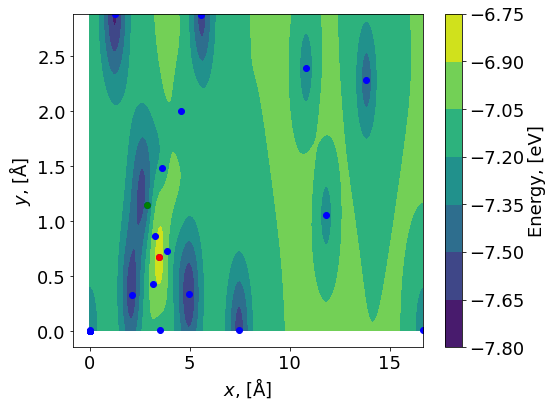

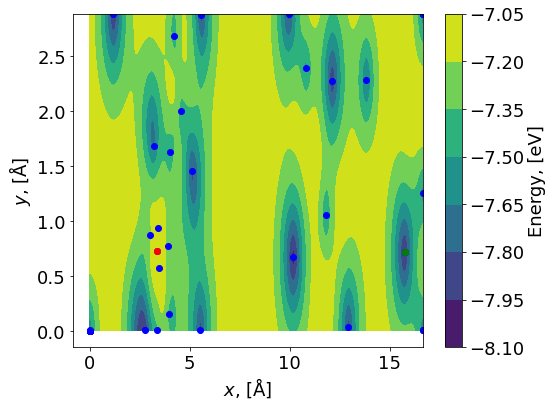

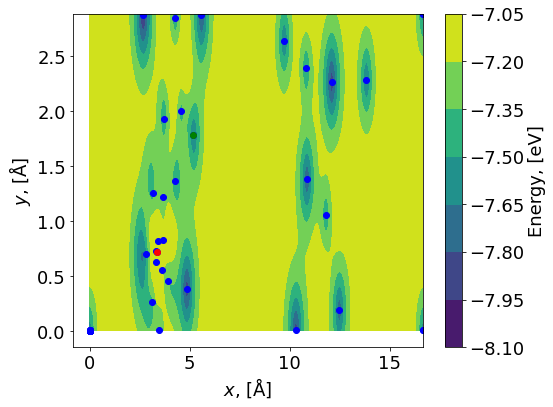

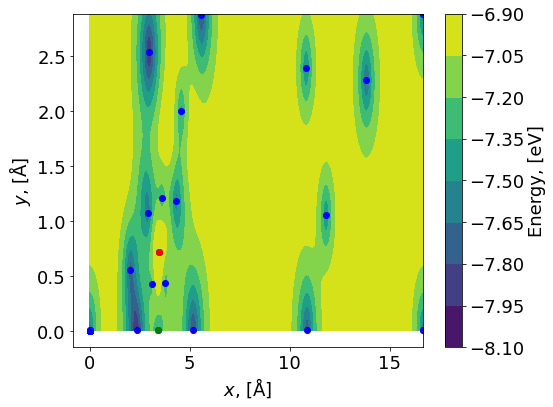

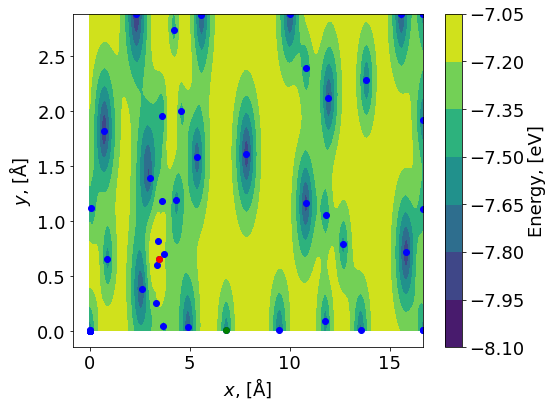

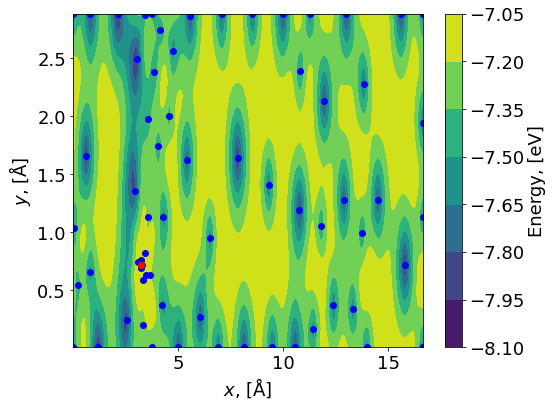

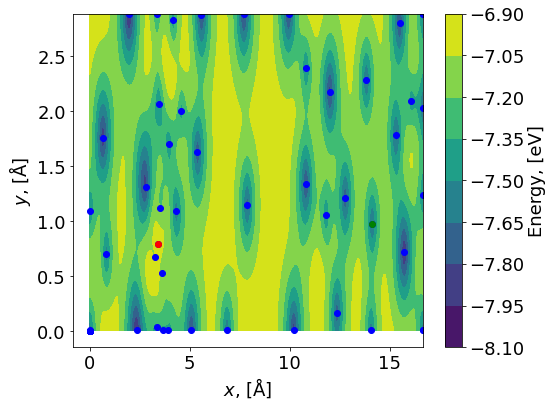

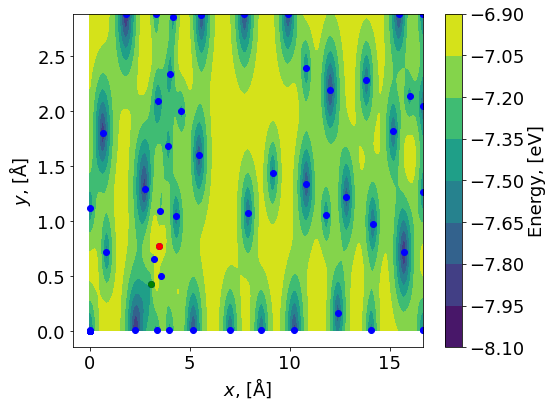

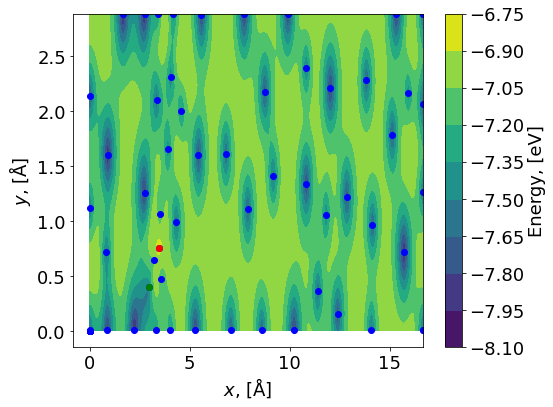

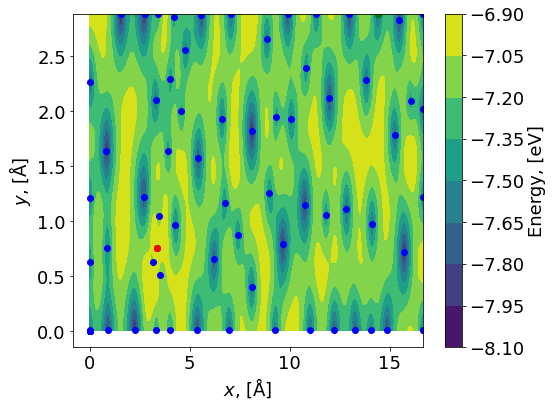

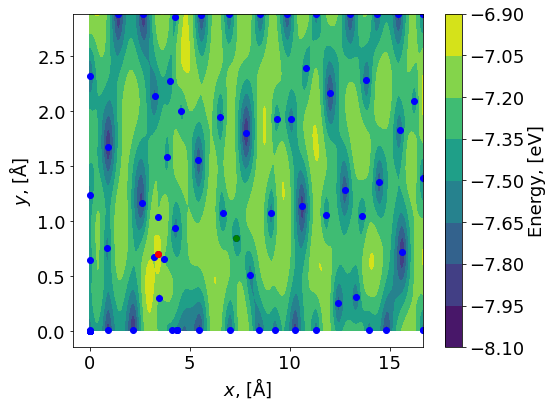

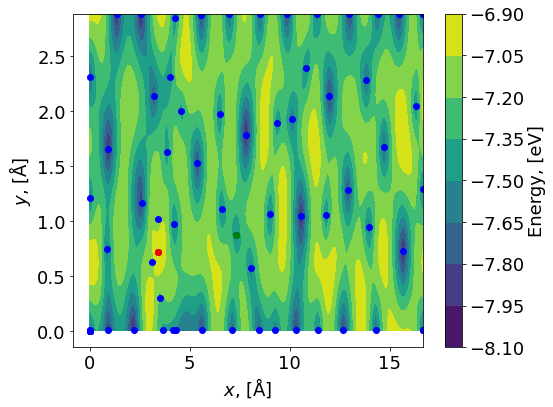

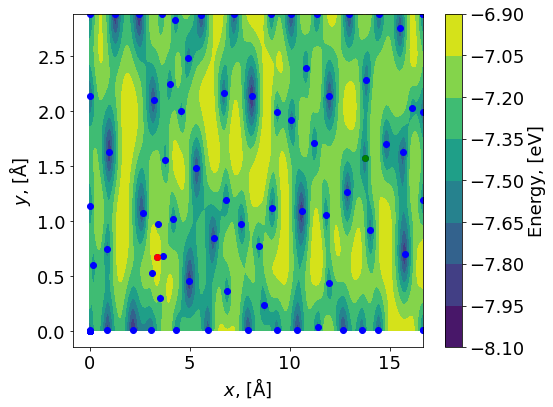

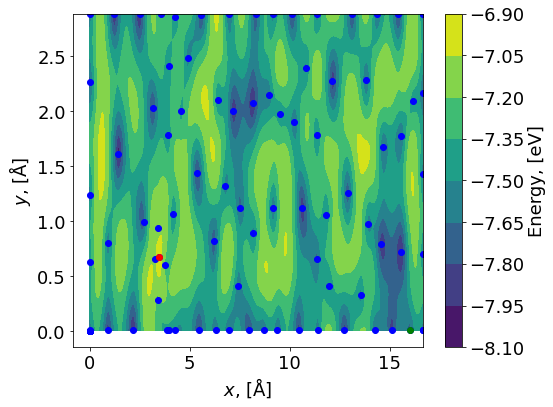

In [9]:
task3_file = 'task3_bayes.p'
n_betas = 20
betas = np.linspace(1,5,n_betas)
iterations = np.zeros(n_betas)
final_Xs = np.zeros((n_betas,2))

if(os.path.isfile(task3_file)):
    print('Loading models, iterations and samples')
    t3_tup = pickle.load(open( task3_file, "rb" ))
    all_iters = t3_tup[0]
    models = t3_tup[1]
    samples = t3_tup[2]
    
else: 
    conv_tol = 1e-1
    max_iters = 100
    n_data = 5
    nx = 1600
    ny = 200

    
    initial_X, initial_E = get_initial_data(n_data)

    all_iters = []
    models = []
    samples = []


    for i,beta in enumerate(betas):
        print(f'Beta={beta:.2f}')
        iters, model, Acq, X = bayesian_optimization(initial_X, initial_E, conv_tol, max_iters, n_data, nx, ny, beta, plot=True, debug=False)
        iterations[i] = iters
        final_Xs[i,:] = X[-1,:]
        print(model)
    #     print(model['sum.std_periodic.lengthscale'])
    #     print(model['sum.std_periodic.period'])
        # Save for pickling
        all_iters.append(iters)
        models.append(model)
        samples.append(X)

    t3_tup = (all_iters, models, samples)
    pickle.dump(t3_tup, open(task3_file, "wb"))


(20,) (20,)


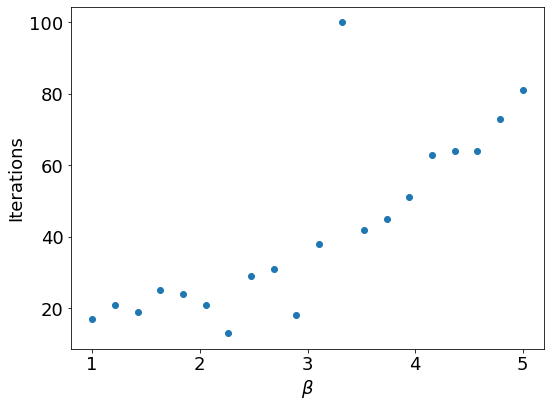

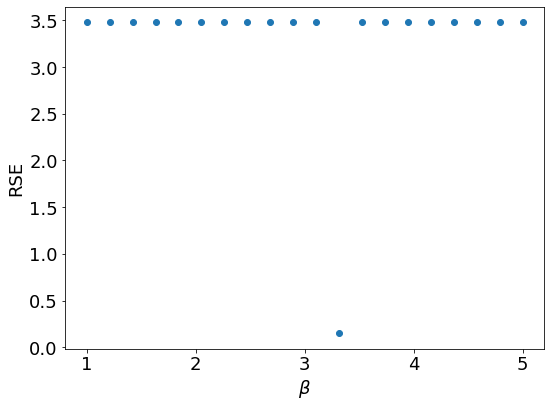

In [18]:
# plot iterations 
fig, ax = plt.subplots(figsize=(8,6))

print(betas.shape, iterations.shape)
ax.scatter(betas, iterations)
#ax.plot(betas, iterations)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'Iterations')
plt.tight_layout()

best_beta = betas[np.argmin(iterations)]

#plot rmse
fig2, ax2 = plt.subplots(figsize=(8,6))
# Obtain X for each beta
dist = np.sqrt((gm_x-X[:,0])**2 + (gm_y-X[:,1])**2)
ax2.scatter(betas, dist)
ax2.set_ylabel('RSE')
ax2.set_xlabel(r'$\beta$')

plt.tight_layout()


(320000, 1)


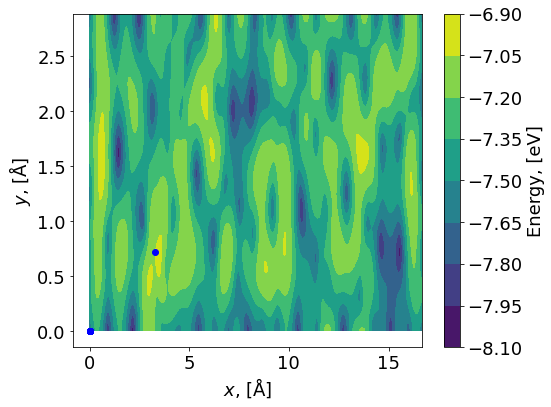

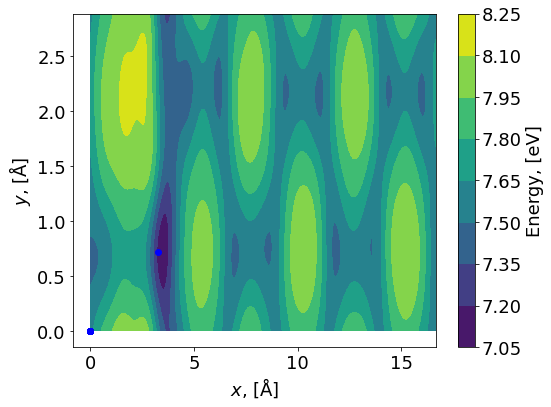

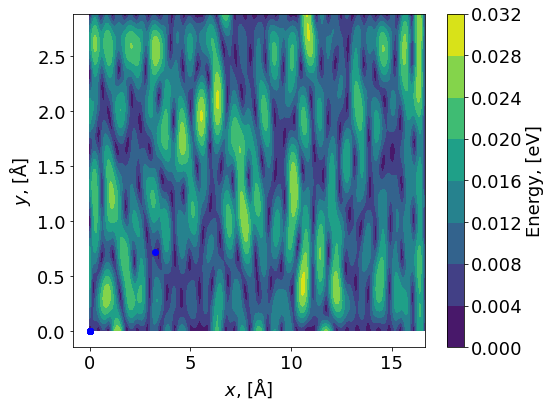

In [17]:
conv_tol = 1e-1
max_iters = 50
n_data = 5
nx = 1600
ny = 200



# best_beta = 4
#iters, model, Acq, X = bayesian_optimization(initial_X, initial_E, conv_tol, max_iters, n_data, nx, ny, best_beta, plot=False, debug=False)
#print(iters)
fGrid = flatten_grid(nx, ny)
mu = model.predict(fGrid)[0] 
sigma = np.sqrt(model.predict(fGrid)[1])

fig1,ax1 = plt.subplots(figsize = (8,6))
plot_on_grid(Acq.reshape(nx,ny).T, ax1, nx, ny)
ax1.scatter(x=X[:,0], y=X[:,1], c='b')
plt.tight_layout()

fig2,ax2 = plt.subplots(figsize = (8,6))
plot_on_grid(mu.reshape(nx,ny).T, ax2, nx, ny)
ax2.scatter(x=X[:,0], y=X[:,1], c='b')
plt.tight_layout()

fig3,ax3 = plt.subplots(figsize = (8,6))
plot_on_grid(sigma.reshape(nx,ny).T, ax3, nx, ny)
ax3.scatter(x=X[:,0], y=X[:,1], c='b')
plt.tight_layout()

print(Acq.shape)

Running Task 4 calculation


 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1


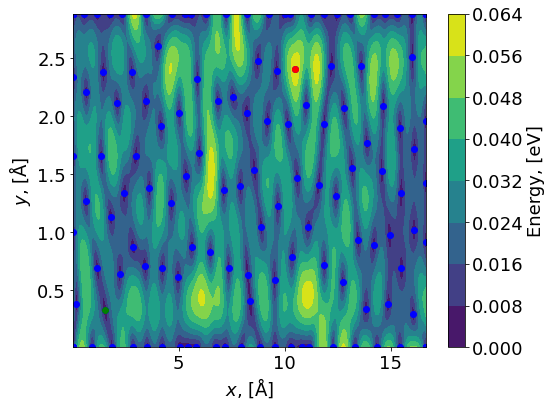

In [27]:
def get_initial_t4(n_data):
    start_x = np.random.rand(n_data-2)*x_max
    start_y = np.random.rand(n_data-2)*y_max
    
    start_x = np.append(start_x, gm_x)
    start_y = np.append(start_y, gm_y)
    
    start_x = np.append(start_x, 11)
    start_y = np.append(start_y, 2.1)

    z = set_z_max(surface.get_positions())
    X_data = np.zeros((n_data,2))
    E_data = np.zeros((n_data,1))
    for i in range(n_data):
        energy = calculate_adatom_energy(surface, [start_x[i], start_y[i], z]) 
        E_data[i] = energy
        X_data[i,0] = start_x[i]
        X_data[i,1] = start_y[i]
    return X_data, E_data

def RMSE(mu_pes, pes):
    mu_pes = mu_pes.reshape(len(xs),len(ys))
    MSE = np.mean((mu_pes - pes)**2, axis=(0,1))
    return np.sqrt(MSE)
    
def grid():
    Xs = np.zeros((len(xs)*len(ys), 2))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            Xs[len(ys)*i+j, 0] = x 
            Xs[len(ys)*i+j, 1] = y
    return Xs

def bayesian_optimization_t4(max_iters, n_data, nx, ny, beta, plot=True, debug=False):
    fig, ax = plt.subplots(figsize=(8,6))
    np.random.seed(9)

    z = set_z_max(surface.get_positions())
    X, E = get_initial_t4(n_data)

    X_new = []
    X_old = X[-1,:]
    rmse = np.zeros(max_iters)
    Xs = grid()
    flat_grid = flatten_grid(nx,ny)
    for i in tqdm(range(max_iters)):
        model = train_GP(X,E)
        X_new, Acq = get_new_X(model, beta, flat_grid, drop_mean=True)
        E_new = calculate_adatom_energy(surface, [X_new[0], X_new[1], z])
        # Update data
        X = np.append(X, X_new.reshape(1,2), axis=0)
        E = np.append(E, np.array([E_new]).reshape(1,1), axis=0)

        # plot Acq function and data
        if plot and i == max_iters-1:
            plot_on_grid(Acq.reshape(nx,ny).T, ax, nx, ny)
            ax.scatter(x=X[:,0], y=X[:,1], c='b')
            ax.scatter(x=X_old[0], y=X_old[1], c='g')
            ax.scatter(x=X_new[0], y=X_new[1], c='r')

        mu_pes, std_pes  = model.predict(Xs)
        rmse[i] = RMSE(mu_pes, pes)
        X_old = X_new
    return rmse, model


task4_file = 'task4.p'

if(os.path.isfile(task4_file)):
    print('Loading task 4 results')
    tup = pickle.load(open( task4_file, "rb" ))
    rmse = tup[0]
    model = tup[1]
else:
    print('Running Task 4 calculation')
    nx = 1600
    ny = 200
    max_iters = 150
    n_data = 5
    beta = 1e3
    rmse, model = bayesian_optimization_t4(max_iters, n_data, nx, ny, beta, plot=True, debug=False)
    tup = (rmse, model)
    pickle.dump(tup, open(task4_file, "wb"))






Name : GP regression
Objective : -308.37699231751606
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |    priors  
  sum.rbf.variance         |      0.0403736743478253  |      +ve      |  Ga(1, 0.1)
  sum.rbf.lengthscale      |      0.6341313471067972  |      +ve      |  Ga(2, 0.5)
  sum.bias.variance        |       59.95170576150982  |      +ve      |            
  Gaussian_noise.variance  |  1.2805187006242829e-34  |      +ve      |            


 /home/ericl/miniconda3/envs/physics/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f588229ded0>]}

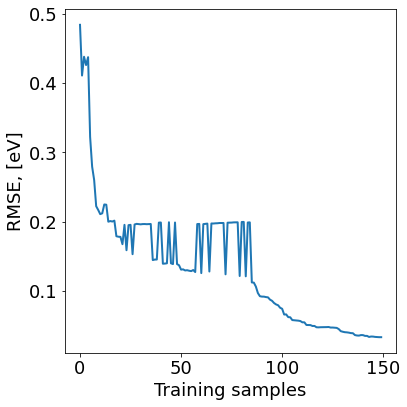

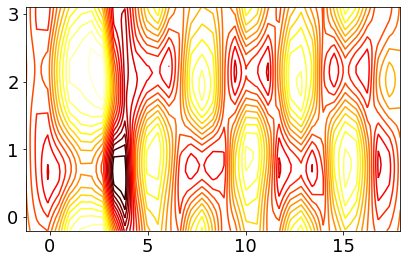

In [28]:
fig,ax = plt.subplots(figsize = (6,6))
ax.plot(rmse, linewidth=2)
ax.set_xlabel('Training samples')
ax.set_ylabel('RMSE, [eV]')
plt.tight_layout()
plt.savefig('figures/task4_train.png')
print(model)
# print(model['sum.std_periodic.lengthscale'])
# print(model['sum.std_periodic.period'])
model.plot_mean()

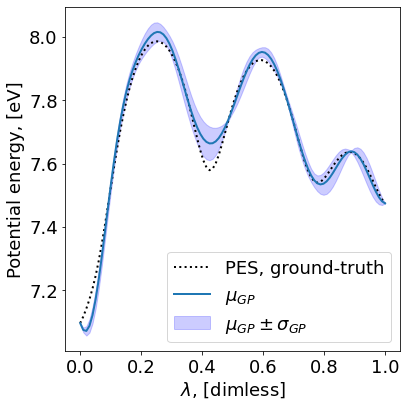

In [29]:
def path(x_end, y_end, n):
    lamb = np.linspace(0,1,n)
    Xs = np.zeros((n,2))
    Xs[:,0] = gm_x + lamb*(x_end-gm_x)
    Xs[:,1] = gm_y + lamb*(y_end-gm_y)
    return Xs, lamb


def evaluate_PES(points):
    z = set_z_max(surface.get_positions())
    E = np.zeros(points.shape[0])
    for i in range(points.shape[0]):
        point = points[i,:]
        E[i] = calculate_adatom_energy(surface, [point[0], point[1], z])
    return E


# GP path
p, lamb = path(11,2.1,100)
mu_pes, std_pes  = model.predict(p)

# EMT path
E = evaluate_PES(p)

# Plot
fig,ax = plt.subplots(figsize = (6,6))

ax.plot(lamb, E, c='k', linewidth=2, linestyle=':', label='PES, ground-truth')
mean = mu_pes[:,0]
err = np.sqrt(std_pes[:,0])
ax.plot(lamb, mean, linewidth=2, label=r'$\mu_{GP}$')
ax.fill_between(x=lamb, y1=mean+err, y2=mean-err, color='b', alpha=0.2, label=r'$\mu_{GP} \pm \sigma_{GP} $')

ax.set_xlabel(r'$\lambda$, [dimless]')
ax.set_ylabel(r'Potential energy, [eV]')
plt.tight_layout()
ax.legend(loc='best')

plt.savefig('figures/task4_path.png')